In [ ]:
!pip install mxnet
!pip install gluonnlp

In [3]:
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon.utils import download
from mxnet import ndarray as nd
import glob
import time
import math
import gluonnlp as nlp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import warnings
warnings.filterwarnings('ignore')

In [4]:
batch_size = 20
bptt = 35
ctx = mx.cpu()


data = "wikitext-2"
data_train, data_val, data_test = [nlp.data.WikiText2(
    segment=segment, bos=None, eos='<eos>', skip_empty=False) 
                                          for segment in ['train', 'val', 'test']]

vocabulary = nlp.Vocab(nlp.data.Counter(data_train), padding_token=None, bos_token=None)

bptt_batchify = nlp.data.batchify.CorpusBPTTBatchify(
    vocabulary, bptt, batch_size, last_batch='discard')
train, val, test = [
    bptt_batchify(x) for x in [data_train, data_val, data_test]
]

In [5]:
models_names = ["standard_lstm_lm_650", "standard_lstm_lm_1500"]
models = dict((name, nlp.model.get_model(name, vocab=vocabulary, dataset_name=data, 
                                         pretrained=True, ctx=ctx)[0]) for name in models_names)

loss = gluon.loss.SoftmaxCrossEntropyLoss()

Vocab file is not found. Downloading.


In [6]:
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [detach(i) for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

def evaluate(model, data, batch_size, ctx, loss=loss, max_steps=150 // batch_size):
    L_sum = 0
    n = 0
    hidden = model.begin_state(batch_size=batch_size, func=mx.nd.zeros, ctx=ctx)
    for i, (data_, target) in enumerate(data):
        data_ = data_.as_in_context(ctx)
        target = target.as_in_context(ctx)
        output, hidden = model(data_, hidden)
        output.wait_to_read()
        hidden = detach(hidden)
        if i > 0:
            L = loss(output.reshape(-3, -1), target.reshape(-1))
            L_sum += mx.nd.sum(L).asscalar()
            n += target.reshape(-1).size
        if i > max_steps:
            break
    return L_sum / n

In [7]:
original_decoder = None
model = models['standard_lstm_lm_650']

In [8]:
%%time
if original_decoder is None:
    original_decoder = model.decoder
else:
    model.decoder = original_decoder
model.hybridize(active=False)
evaluate(model, test, batch_size, ctx, loss=loss)

CPU times: user 7.67 s, sys: 60.8 ms, total: 7.73 s
Wall time: 7.91 s


In [9]:
class Softmax(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def hybrid_forward(self, F, x):
        return F.softmax(x, axis=-1)

class SVDSoftmax(gluon.HybridBlock):
    def __init__(self, svd_decomposition, bias, W=10, N=100, approx=False, activation=False, **kwargs):
        super().__init__(**kwargs)
        u, s, vh = svd_decomposition
        B = u @ np.diag(s)
        self.W = W
        self.N = min(N, B.shape[0])
        self.approx = approx
        self.activation = activation
        self.n_features = vh.shape[0]
        self.n_classes = B.shape[0]
        with self.name_scope():
            self.B = self.params.get('B', shape=B.shape, init=mx.init.Constant(B.tolist()), differentiable=False)
            self.vh = self.params.get('vh', shape=vh.shape, init=mx.init.Constant(vh.tolist()), differentiable=False)
            self.bias = self.params.get('bias', shape=bias.shape, init=mx.init.Constant(bias.tolist()), differentiable=False)


    def hybrid_forward(self, F, x, B, vh, bias):
        x = F.reshape(x, shape=(-3, -1))
        h = F.FullyConnected(x, weight=vh, no_bias=True, num_hidden=self.n_features, flatten=False)
        h_prev = F.slice_axis(h, axis=-1, begin=0, end=self.W)
        B_prev = F.slice_axis(B, axis=1, begin=0, end=self.W)
        z_prev = F.FullyConnected(h_prev, weight=B_prev, bias=bias, no_bias=False, num_hidden=self.n_classes, flatten=False)
        if self.approx:
            if self.activation:
                z_prev = F.softmax(z_prev, axis=-1)
            return F.reshape(z_prev, shape=(batch_size, bptt, self.n_classes))
        
        best_indices = F.topk(z_prev, axis=-1, ret_typ='indices', k=self.N)
        best_logits = [F.dot(B[best_indices[i]], h[i]) + bias[best_indices[i]] for i in range(batch_size * bptt)]
        z = z_prev
        for i in range(batch_size * bptt):
            z[i, best_indices[i]] = best_logits[i]
        if self.activation:
            z = F.softmax(z, axis=-1)
        return F.reshape(z, shape=(batch_size, bptt, self.n_classes))

In [16]:
def get_weights_and_bias(model):
    W_end = "_hybridsequential0_embedding0_weight"
    b_end = "_hybridsequential0_embedding0_bias"
    W = None
    b = None
    params = model.collect_params()
    for param in params.keys():
        if param.endswith(W_end):
            W = params[param].data().asnumpy()
        elif param.endswith(b_end):
            b = params[param].data().asnumpy()
    return W, b

def get_svd_and_bias(model):
    W, b = get_weights_and_bias(model)
    u, s, vh = np.linalg.svd(W, full_matrices=False)
    return (u, s, vh), b

def create_new_decoder(model, W=10, N=100, approx=False):
    svd, bias = get_svd_and_bias(model)
    new_decoder = gluon.nn.HybridSequential()
    new_decoder.add(SVDSoftmax(svd, bias, W=W, N=N, approx=approx))
    new_decoder.initialize()
    return new_decoder

def softmax_decoder(model, W=10, N=100, return_full=False):
    svd, bias = get_svd_and_bias(model)
    new_decoder = gluon.nn.HybridSequential()
    new_decoder.add(model.decoder[0])
    new_decoder.add(Softmax())
    new_decoder.initialize()
    return new_decoder

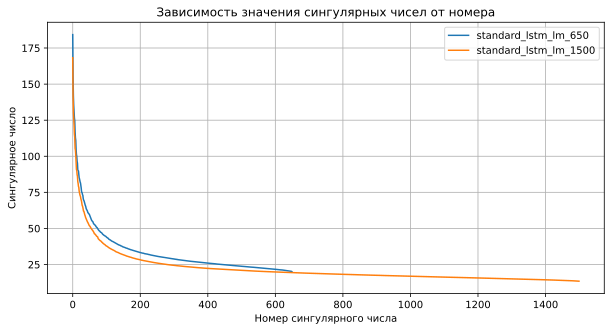

In [ ]:
plt.figure(figsize=(10,5))
for name, model in models.items():
    svd, b = get_svd_and_bias(model)
    plt.plot(svd[1], label=name)

plt.xlabel("Номер сингулярного числа")
plt.ylabel("Сингулярное число")
plt.title("Зависимость значения сингулярных чисел от номера")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import tqdm

In [14]:
%%time
model.decoder = original_decoder
model.decoder = create_new_decoder(model, W=30, N=3000, approx=True)
model.hybridize(active=False)
evaluate(model, test, batch_size, ctx, loss=loss)

CPU times: user 15.5 s, sys: 2.52 s, total: 18.1 s
Wall time: 13.3 s


In [15]:
%%time
model.decoder = original_decoder
model.decoder = create_new_decoder(model, W=30, N=3000, approx=False)
model.hybridize(active=False)
evaluate(model, test, batch_size, ctx, loss=loss)

CPU times: user 1min 16s, sys: 4.24 s, total: 1min 21s
Wall time: 58.7 s


In [18]:
%%time
model.decoder = original_decoder
model.decoder = softmax_decoder(model, W=30, N=3000)
model.hybridize(active=False)
evaluate(model, test, batch_size, ctx, loss=loss)

CPU times: user 16 s, sys: 908 ms, total: 16.9 s
Wall time: 12.9 s


In [140]:
%%time
perplexes = []
N = 3200
W = [1, 5, 10, 15, 20, 25, 50, 75, 100, 125, 150]
for W_ in tqdm.tqdm(W):
    model.decoder = original_decoder
    model.decoder = create_new_decoder(model, W=W_, N=N)
    model.hybridize(active=False)
    perpl = evaluate(model, test, batch_size, ctx, loss=loss)
    perplexes.append(perpl)

100%|██████████| 11/11 [13:27<00:00, 73.44s/it]

CPU times: user 17min 33s, sys: 37.5 s, total: 18min 11s
Wall time: 13min 27s


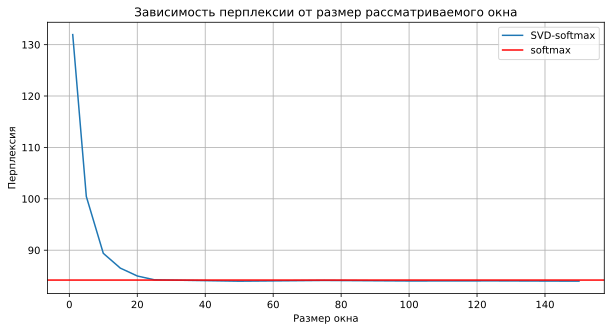

In [143]:
plt.figure(figsize=(10,5))
plt.plot(W, np.exp(perplexes), label="SVD-softmax")
plt.axhline(np.exp(standard), color='red', label="softmax")
plt.title("Зависимость перплексии от размер рассматриваемого окна")
plt.ylabel("Перплексия")
plt.xlabel("Размер окна")
plt.legend()
plt.grid(True)
plt.show()

In [137]:
%%time
W = 25
perplexes = []
N = [1, 5, 10, 25, 50, 75, 100, 200, 500, 1000, 2000, 4000]
for N_ in tqdm.tqdm(N):
    model.decoder = original_decoder
    model.decoder = create_new_decoder(model, W=W, N=N_)
    model.hybridize(active=False)
    perpl = evaluate(model, test, batch_size, ctx, loss=loss)
    perplexes.append(perpl)

100%|██████████| 12/12 [08:38<00:00, 43.22s/it]

CPU times: user 11min 53s, sys: 38.8 s, total: 12min 32s
Wall time: 8min 38s


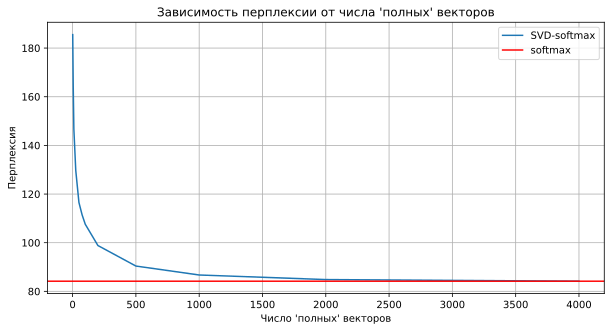

In [138]:
plt.figure(figsize=(10,5))
plt.plot(N, np.exp(perplexes), label="SVD-softmax")
plt.axhline(np.exp(standard), c='red', label="softmax")
plt.xlabel("Число 'полных' векторов")
plt.ylabel("Перплексия")
plt.title("Зависимость перплексии от числа 'полных' векторов")
plt.grid(True)
plt.legend()
plt.savefig('')